Here we implement the RNN model: https://github.com/0aqz0/SLR/blob/master/models/ConvLSTM.py

## 1 Load Data

In [11]:
import os
import shutil
import pandas as pd
import numpy as np
from numpy import asarray
import cv2 as cv
import re
import math
from subprocess import check_call, PIPE, Popen
import shlex
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torchvision import models
from torch import nn
import torcheval
from torcheval.metrics.functional import multiclass_auprc
from torch.utils.data import Dataset, DataLoader, Subset
import glob
import random
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt

In [6]:
upperlimit = 1000
cutoff = 247
train = pd.read_pickle("data/noorstorage/CorpusNGT/train_cutoff{}_upperlimit{}.pkl".format(cutoff, upperlimit))
test  = pd.read_pickle("data/noorstorage/CorpusNGT/test_cutoff{}_upperlimit{}.pkl".format(cutoff, upperlimit))
val   = pd.read_pickle("data/noorstorage/CorpusNGT/validate_cutoff{}_upperlimit{}.pkl".format(cutoff, upperlimit))

In [8]:
tr = (train["id"]).unique() ## So there are 157 classes in this dataset of which each have about
va = (val["id"]).unique()
te = (test["id"]).unique()
total = np.concatenate((tr, va, te), axis=0, out=None)
total = np.unique(total)
total = np.sort(total)
print(len(total))
print(len(train))                ## 156.5 instances per class on average.

50
17729


In [9]:
catgs = total
num_classes = len(catgs)
labels_dict = {}
ind = 0
for uc in catgs:
    labels_dict[uc] = ind
    ind+=1

def preprocess_datasubset(split):
    split_labels = split["id"].tolist()
    split_ids = split["path"].tolist()
    print(len(split_ids), len(split_labels))
    return split_ids, split_labels

train_ids, train_labels = preprocess_datasubset(train)
test_ids, test_labels = preprocess_datasubset(test)
val_ids, val_labels = preprocess_datasubset(val)

17729 17729
2217 2217
2216 2216


In [10]:
print(labels_dict)

{'1-A': 0, 'AL': 1, 'BEDOELEN': 2, 'BINNEN': 3, 'BLIJVEN': 4, 'DAN-A': 5, 'DENKEN': 6, 'DOOF-A': 7, 'DOOF-B': 8, 'DOOF-C': 9, 'GAAN': 10, 'GEBAREN-A': 11, 'GEHANDICAPT-A': 12, 'GOED-A': 13, 'GROEP-A': 14, 'HEBBEN-A': 15, 'HEE': 16, 'HOREN-A': 17, 'JA-A': 18, 'KIJKEN-A': 19, 'KLAAR-A': 20, 'KOMEN-A': 21, 'KUNNEN-A': 22, 'LAAT-MAAR': 23, 'MAAR': 24, 'MOETEN-A': 25, 'MOOI-A': 26, 'MOVE-EC-1': 27, 'MOVE-EC-2R': 28, 'MOVE-EC-4': 29, 'NIET-A': 30, 'NU-A': 31, 'OF': 32, 'ONDERWIJS': 33, 'PLUS': 34, 'PO': 35, 'POPT': 36, 'PT': 37, 'PV': 38, 'RUIMTE': 39, 'SAMEN-A': 40, 'TAAL-B': 41, 'TOCH-A': 42, 'VROEGER-A': 43, 'WETEN-A': 44, 'ZEGGEN': 45, 'ZELF': 46, 'ZELFDE-A': 47, 'ZIEN-A': 48, 'ZO-A': 49}


### 2 Datasets and Transforms

In [12]:
np.random.seed(2024)
random.seed(2024)
torch.manual_seed(2024)

In [41]:
# Choose some of the data transform values

timesteps = 8

data_aug = False
batch_size = 16

h, w =224, 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# h, w = 270, 270
# mean = [0.43216, 0.394666, 0.37645]
# std = [0.22803, 0.22145, 0.216989]

In [42]:
class VideoDataset(Dataset):
    def __init__(self, ids, labels, transform):
        self.transform = transform
        self.ids = ids
        self.labels = labels
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        path2imgs=glob.glob(self.ids[idx]+"/*.jpg")
        path2imgs = path2imgs[:timesteps]
        label = labels_dict[self.labels[idx]]
        frames = []
        for p2i in path2imgs:
            frame = Image.open(p2i)
            frames.append(frame)

        seed = np.random.randint(1e9)
        frames_tr = []
        for frame in frames:
            random.seed(seed)
            np.random.seed(seed)
            frame = self.transform(frame)
            frames_tr.append(frame)
        if len(frames_tr)>0:
            frames_tr = torch.stack(frames_tr)
        return frames_tr, label

In [43]:
# define helper functions

def transform_frames(frames):
    test_transformer = transforms.Compose([
                transforms.Resize((h,w)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)])

    frames_tr = []
    for frame in frames:
        frame = Image.fromarray(frame)
        frame_tr = test_transformer(frame)
        frames_tr.append(frame_tr)
    imgs_tensor = torch.stack(frames_tr)

        # imgs_tensor = torch.transpose(imgs_tensor, 1, 0)
    imgs_tensor = imgs_tensor.unsqueeze(0)
    return imgs_tensor


def denormalize(x_, mean, std):
    x = x_.clone()
    for i in range(3):
        x[i] = x[i]*std[i]+mean[i]
    x = to_pil_image(x)
    return x

In [44]:
train_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])


train_ds = VideoDataset(ids= train_ids, labels= train_labels, transform= train_transformer)
print(len(train_ds))

print(train_ds)

17729


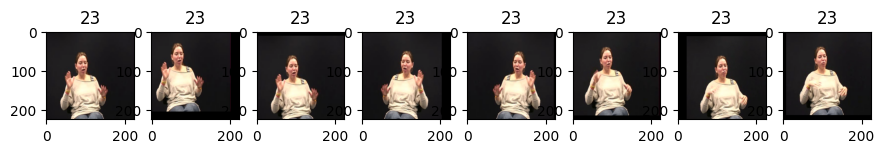

In [45]:
%matplotlib inline

# inspect
imgs, label = train_ds[10]
imgs.shape, label, torch.min(imgs), torch.max(imgs)

## For image condition, not keypoints
plt.figure(figsize=(12,12))
for ii,img in enumerate(imgs[::1]):
    plt.subplot(2,9,ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.title(label)

In [46]:
test_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])

test_ds = VideoDataset(ids= test_ids, labels= test_labels, transform= test_transformer)
print(len(test_ds))
val_ds = VideoDataset(ids= val_ids, labels= val_labels, transform= test_transformer)
print(len(val_ds))

2217
2216


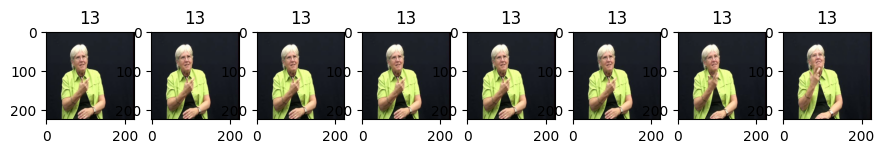

In [47]:
imgs, label = test_ds[5]
imgs.shape, label, torch.min(imgs), torch.max(imgs)
plt.figure(figsize=(12,12))
for ii,img in enumerate(imgs[::1]):
    plt.subplot(2,9,ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.title(label)

### 3 Dataloader

In [48]:
def collate_fn(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    imgs_tensor = torch.transpose(imgs_tensor, 2, 1)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor


train_dl = DataLoader(train_ds, batch_size= batch_size,
                      shuffle=True, collate_fn= collate_fn)
test_dl = DataLoader(test_ds, batch_size= batch_size,
                     shuffle=False, collate_fn= collate_fn)
val_dl = DataLoader(val_ds, batch_size= batch_size,
                     shuffle=False, collate_fn= collate_fn)

In [49]:
for xb,yb in train_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([16, 3, 8, 224, 224]) torch.Size([16])


### 4 Define Model

In [79]:
## Here a we implement the ResNet network from the GitHub Repo

import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.video import r3d_18  # Import pre-trained 3D ResNet-18

"""
Implementation of 3D ResNet
"""

class BasicBlock3D(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(BasicBlock3D, self).__init__()
        self.conv1 = nn.Conv3d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

class ResNet3D(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet3D, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv3d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv3d(self.in_planes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.in_planes, planes, stride, downsample))
        self.in_planes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        # x shape: (batch_size, 3, 8, 224, 224)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def resnet3d18(num_classes):
    return ResNet3D(BasicBlock3D, [2, 2, 2, 2], num_classes=num_classes)

In [80]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [81]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

def acc_epoch(correct_preds, total_preds):
    """
    Calculates the accuracy for the epoch.
    """
    return correct_preds / total_preds if total_preds > 0 else 0.0

def loss_epoch(running_loss, dataset_size):
    """
    Calculates the average loss for the epoch.
    """
    return running_loss / dataset_size

def iou_epoch(preds, labels, num_classes):
    """
    Calculates the mean IoU for the epoch.
    """
    iou_per_class = []

    for cls in range(num_classes):
        intersection = ((preds == cls) & (labels == cls)).sum().item()
        union = ((preds == cls) | (labels == cls)).sum().item()
        if union == 0:
            iou_per_class.append(1.0)  # If no instances of the class are present, IoU is 1
        else:
            iou_per_class.append(intersection / union)
    
    return sum(iou_per_class) / num_classes

def calculate_precision(preds, labels, num_classes):
    """Calculate overall and per-class precision."""
    per_class_correct = torch.zeros(num_classes).to(preds.device)
    per_class_total = torch.zeros(num_classes).to(preds.device)

    for cls in range(num_classes):
        per_class_correct[cls] += ((preds == cls) & (labels == cls)).sum().item()
        per_class_total[cls] += (labels == cls).sum().item()

    per_class_precision = per_class_correct / (per_class_total + 1e-8)  # Avoid division by zero
    overall_precision = per_class_correct.sum() / (per_class_total.sum() + 1e-8)
    return overall_precision.item(), per_class_precision.cpu().numpy()

def train_model_with_metrics(model, train_loader, val_loader, criterion, optimizer, device, num_epochs, num_classes):
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []
    train_precision, val_precision = [], []
    train_precision_per_class, val_precision_per_class = [], []

    try:
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            running_loss = 0.0
            correct_preds = 0
            total_preds = 0
            precision_per_class = np.zeros(num_classes)

            for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # Update running loss
                running_loss += loss.item() * inputs.size(0)

                # Update accuracy and precision
                preds = torch.argmax(outputs, dim=1)
                correct_preds += (preds == labels).sum().item()
                total_preds += labels.size(0)

                # Per-class precision
                _, class_precision = calculate_precision(preds, labels, num_classes)
                precision_per_class += class_precision

            epoch_train_loss = running_loss / len(train_loader.dataset)
            epoch_train_acc = correct_preds / total_preds
            epoch_train_precision = precision_per_class.mean()

            train_loss.append(epoch_train_loss)
            train_acc.append(epoch_train_acc)
            train_precision.append(epoch_train_precision)
            train_precision_per_class.append(precision_per_class / len(train_loader))

            # Validation phase
            model.eval()
            running_loss = 0.0
            correct_preds = 0
            total_preds = 0
            precision_per_class = np.zeros(num_classes)

            with torch.no_grad():
                for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                    inputs, labels = inputs.to(device), labels.to(device)

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # Update running loss
                    running_loss += loss.item() * inputs.size(0)

                    # Update accuracy and precision
                    preds = torch.argmax(outputs, dim=1)
                    correct_preds += (preds == labels).sum().item()
                    total_preds += labels.size(0)

                    # Per-class precision
                    _, class_precision = calculate_precision(preds, labels, num_classes)
                    precision_per_class += class_precision

            epoch_val_loss = running_loss / len(val_loader.dataset)
            epoch_val_acc = correct_preds / total_preds
            epoch_val_precision = precision_per_class.mean()

            val_loss.append(epoch_val_loss)
            val_acc.append(epoch_val_acc)
            val_precision.append(epoch_val_precision)
            val_precision_per_class.append(precision_per_class / len(val_loader))

            # Log metrics for the epoch
            print(f"Epoch {epoch+1}/{num_epochs} Summary:")
            print(f"Training Loss: {epoch_train_loss:.4f}, Accuracy: {epoch_train_acc:.4f}, Precision: {epoch_train_precision:.4f}")
            print(f"Validation Loss: {epoch_val_loss:.4f}, Accuracy: {epoch_val_acc:.4f}, Precision: {epoch_val_precision:.4f}")
    except Exception as e:
        print(f"Error: {e}")

    return train_loss, val_loss, train_acc, val_acc, train_precision, val_precision, train_precision_per_class, val_precision_per_class

In [84]:
model = resnet3d18(num_classes=num_classes)  # Adjust num_classes for your dataset
model = model.to(device)
x = torch.randn(1, 3, 16, 112, 112).to(device)  # Example input (Batch x Channels x Depth x Height x Width)
output = model(x)
print(output.shape)  # Should output torch.Size([1, 10])
print(output)

modelweights = "Models/ResNet3D18_test1"
torch.save(model.state_dict(), modelweights)
num_epochs = 16
learning_rate = 1e-3
print(batch_size)
modelname = "ResNet3D18"

torch.Size([1, 50])
tensor([[ 0.2582,  0.0706,  0.6120,  0.6982,  0.6506, -0.8437, -0.4858,  0.2507,
         -0.2159, -0.1272, -0.6491, -0.2970, -0.6512, -0.4989,  0.3909, -1.0279,
          0.1645,  0.0387, -0.3393, -0.2372,  0.4232, -0.2457,  0.1437, -0.0016,
         -0.6000,  0.0831, -0.1828,  0.2210,  0.0873, -0.5257, -0.1302, -0.2743,
         -0.2389,  0.8854,  0.2635,  0.6352, -0.0149, -0.0656,  0.1587,  0.4080,
          0.3122,  0.4451,  0.4420, -0.6274,  0.1068,  0.6313, -0.7071, -0.1092,
         -0.5705,  0.2451]], device='cuda:0', grad_fn=<AddmmBackward0>)
16


Epoch 1/16 - Validation: 100%|██████████| 139/139 [00:36<00:00,  3.86it/s]


Epoch 1/16 Summary:
Training Loss: 3.7534, Accuracy: 0.1018, Precision: 26.8377
Validation Loss: 3.7536, Accuracy: 0.0970, Precision: 3.1450


Epoch 2/16 - Validation: 100%|██████████| 139/139 [00:37<00:00,  3.73it/s]


Epoch 2/16 Summary:
Training Loss: 3.6381, Accuracy: 0.1254, Precision: 33.4397
Validation Loss: 3.7387, Accuracy: 0.1069, Precision: 3.4417


Epoch 3/16 - Validation: 100%|██████████| 139/139 [00:37<00:00,  3.69it/s]


Epoch 3/16 Summary:
Training Loss: 3.5814, Accuracy: 0.1384, Precision: 36.7780
Validation Loss: 3.6047, Accuracy: 0.1372, Precision: 4.4100


Epoch 4/16 - Validation: 100%|██████████| 139/139 [00:39<00:00,  3.51it/s]


Epoch 4/16 Summary:
Training Loss: 3.5273, Accuracy: 0.1501, Precision: 39.8410
Validation Loss: 3.6232, Accuracy: 0.1277, Precision: 4.2433


Epoch 5/16 - Validation: 100%|██████████| 139/139 [00:38<00:00,  3.65it/s]


Epoch 5/16 Summary:
Training Loss: 3.4814, Accuracy: 0.1570, Precision: 41.1237
Validation Loss: 3.6998, Accuracy: 0.1178, Precision: 3.9733


Epoch 6/16 - Validation: 100%|██████████| 139/139 [00:36<00:00,  3.78it/s]


Epoch 6/16 Summary:
Training Loss: 3.4321, Accuracy: 0.1640, Precision: 44.5057
Validation Loss: 3.5789, Accuracy: 0.1232, Precision: 4.0800


Epoch 7/16 - Validation: 100%|██████████| 139/139 [00:37<00:00,  3.73it/s]


Epoch 7/16 Summary:
Training Loss: 3.3744, Accuracy: 0.1721, Precision: 45.8280
Validation Loss: 3.5431, Accuracy: 0.1232, Precision: 4.1817


Epoch 8/16 - Validation: 100%|██████████| 139/139 [00:37<00:00,  3.69it/s]


Epoch 8/16 Summary:
Training Loss: 3.3197, Accuracy: 0.1818, Precision: 48.8353
Validation Loss: 3.4075, Accuracy: 0.1656, Precision: 5.4967


Epoch 9/16 - Validation: 100%|██████████| 139/139 [00:38<00:00,  3.65it/s]


Epoch 9/16 Summary:
Training Loss: 3.2707, Accuracy: 0.1883, Precision: 50.8443
Validation Loss: 3.5223, Accuracy: 0.1250, Precision: 4.2833


Epoch 10/16 - Validation: 100%|██████████| 139/139 [00:37<00:00,  3.68it/s]


Epoch 10/16 Summary:
Training Loss: 3.2119, Accuracy: 0.1971, Precision: 54.2747
Validation Loss: 3.5068, Accuracy: 0.1458, Precision: 5.0117


Epoch 11/16 - Validation: 100%|██████████| 139/139 [00:36<00:00,  3.79it/s]


Epoch 11/16 Summary:
Training Loss: 3.1568, Accuracy: 0.2051, Precision: 56.0183
Validation Loss: 3.4506, Accuracy: 0.1561, Precision: 5.3650


Epoch 12/16 - Validation: 100%|██████████| 139/139 [00:38<00:00,  3.60it/s]


Epoch 12/16 Summary:
Training Loss: 3.1078, Accuracy: 0.2108, Precision: 58.1957
Validation Loss: 3.4863, Accuracy: 0.1444, Precision: 5.0217


Epoch 13/16 - Validation: 100%|██████████| 139/139 [00:36<00:00,  3.81it/s]


Epoch 13/16 Summary:
Training Loss: 3.0566, Accuracy: 0.2206, Precision: 61.4373
Validation Loss: 3.4204, Accuracy: 0.1458, Precision: 5.0633


Epoch 14/16 - Validation: 100%|██████████| 139/139 [00:39<00:00,  3.55it/s]


Epoch 14/16 Summary:
Training Loss: 2.9989, Accuracy: 0.2316, Precision: 64.1070
Validation Loss: 3.4057, Accuracy: 0.1602, Precision: 5.6150


Epoch 15/16 - Validation: 100%|██████████| 139/139 [00:37<00:00,  3.69it/s]


Epoch 15/16 Summary:
Training Loss: 2.9567, Accuracy: 0.2384, Precision: 66.8133
Validation Loss: 3.4152, Accuracy: 0.1507, Precision: 5.1717


Epoch 16/16 - Validation: 100%|██████████| 139/139 [00:37<00:00,  3.68it/s]


Epoch 16/16 Summary:
Training Loss: 2.9057, Accuracy: 0.2490, Precision: 69.8723
Validation Loss: 3.2926, Accuracy: 0.1728, Precision: 5.8600


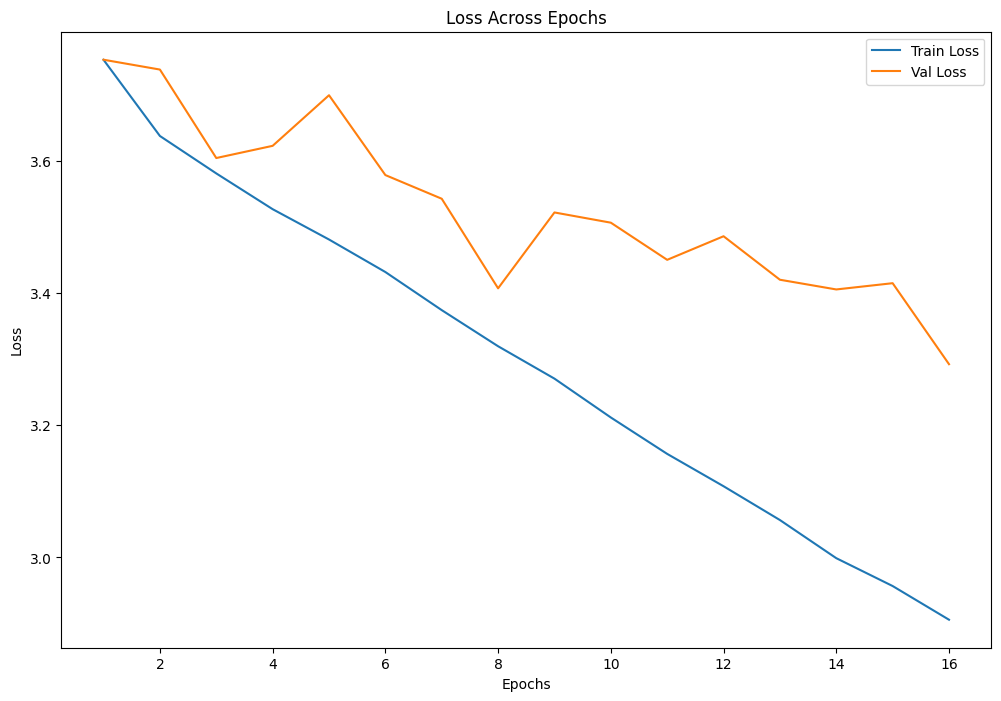

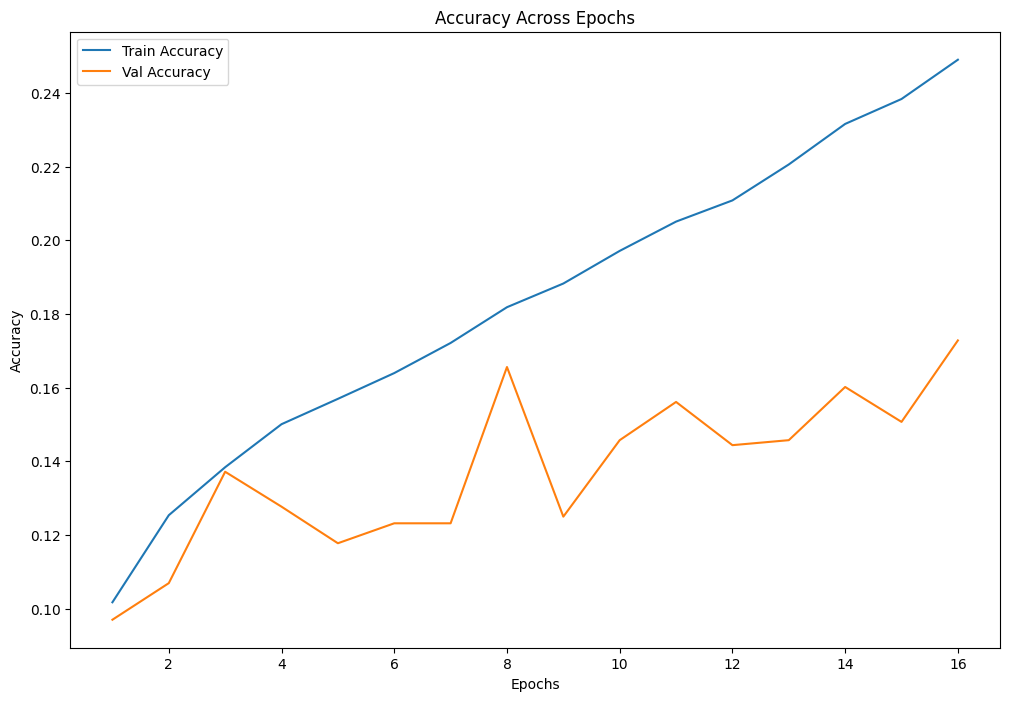

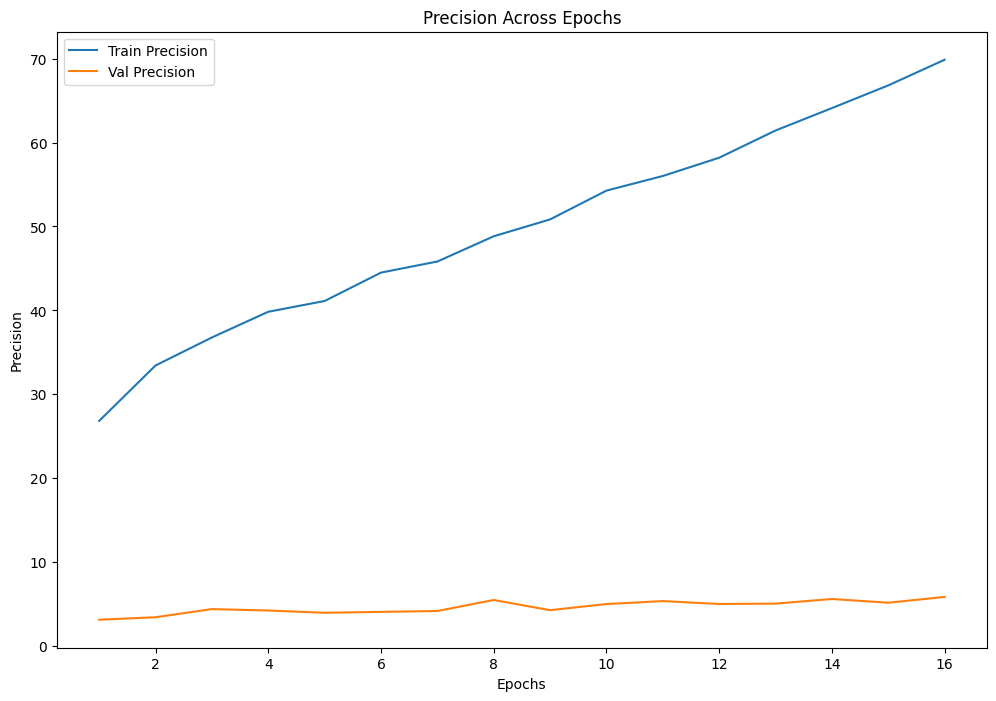

NameError: name 'class_names' is not defined

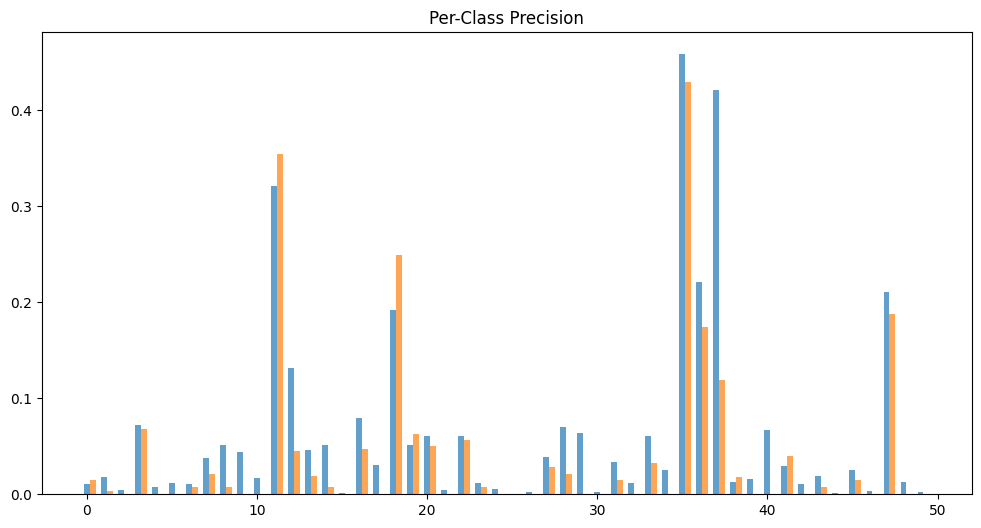

In [85]:
# Training the model
# Assuming `train_model_with_metrics` and the rest of the code are set up
from torch import nn, optim

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss, val_loss, train_acc, val_acc, train_precision, val_precision, train_precision_per_class, val_precision_per_class = train_model_with_metrics(
    model=model,
    num_classes=num_classes,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_dl,
    val_loader=val_dl,
    num_epochs=num_epochs,
    device=device
)

# Plotting results
epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure(figsize=(12, 8))
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Across Epochs')
plt.show()

# Accuracy plot
plt.figure(figsize=(12, 8))
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Across Epochs')
plt.show()

# Precision plot
plt.figure(figsize=(12, 8))
plt.plot(epochs, train_precision, label='Train Precision')
plt.plot(epochs, val_precision, label='Val Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision Across Epochs')
plt.show()

# Plot per-class precision as histograms
last_train_precision = train_precision_per_class[-1]
last_val_precision = val_precision_per_class[-1]

bar_width = 0.35
indices = np.arange(num_classes)

plt.figure(figsize=(12, 6))
plt.bar(indices, last_train_precision, bar_width, label='Train Precision', alpha=0.7)
plt.bar(indices + bar_width, last_val_precision, bar_width, label='Validation Precision', alpha=0.7)
plt.title('Per-Class Precision')
plt.xlabel('Class Index' if class_names is None else 'Class Name')
plt.ylabel('Precision')
plt.xticks(indices + bar_width / 2, class_names if class_names else indices)
plt.legend()
plt.tight_layout()
plt.show()